# MLP
> Create a multilayer perceptron using the Neuron class.
> The mlp has functionality to add or remove nodes during training.

In [ ]:
#| default_exp mlp

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| export
import jax
import jax.numpy as jnp
import numpy as np
import equinox as eqx
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
import matplotlib.style as mplstyle
import seaborn as sns

from NeuralNetworkEvolution.neuron import Neuron
from NeuralNetworkEvolution.activations import identity
from NeuralNetworkEvolution.config import MLPConfig

In [ ]:
#| export
class CustomMLP(eqx.Module):
    layers: list

    def __init__(self, MLPConfig: MLPConfig):
        input_size = MLPConfig.input_size
        output_size = MLPConfig.output_size
        hidden_sizes = MLPConfig.hidden_sizes
        activation_list = MLPConfig.initial_activation_list
        bias = MLPConfig.bias
        key = jax.random.PRNGKey(MLPConfig.seed)
        keys = jax.random.split(key, len(hidden_sizes) + 1)
        act_key = jax.random.split(keys[-1], 1)[0]
        layers = []
        in_features = input_size

        # Create hidden layers
        for i, out_features in enumerate(hidden_sizes):
            layer = [Neuron(in_features, activation_list[jax.random.choice(key, jnp.arange(len(activation_list)))], bias= bias, key=key) 
                        for i, key in enumerate(jax.random.split(act_key, out_features))]
            layers.append(layer)
            in_features = out_features

        # Create output layer
        output_layer = [Neuron(in_features, activation=identity, key=keys[-1]) for _ in range(output_size)]
        layers.append(output_layer)

        self.layers = layers

    def __call__(self, x):
        for layer in self.layers:
            x = jnp.array([neuron(x) for neuron in layer])
        return x

    def add_neuron(self, layer_index, activation=jax.nn.relu, bias = False, key=None):
        if key is None:
            key = jax.random.PRNGKey(0)
        in_features = self.layers[layer_index][0].weight.shape[0]
        new_neuron = Neuron(in_features, activation, bias, key)
        self.layers[layer_index].append(new_neuron)

        # Adjust the next layer's weight matrix to include the new neuron
        if layer_index + 1 < len(self.layers):
            for i, next_neuron in enumerate(self.layers[layer_index + 1]):
                new_weight = jax.random.normal(key, (1,))
                updated_weights = jnp.append(next_neuron.weight, new_weight)
                self.layers[layer_index + 1][i] = eqx.tree_at(lambda n: n.weight, next_neuron, updated_weights)

    def remove_neuron(self, layer_index, neuron_index):
        if len(self.layers[layer_index]) > 0:
            del self.layers[layer_index][neuron_index]
        
        # Adjust the next layer's weight matrix to remove the corresponding weight
        if layer_index + 1 < len(self.layers):
            for i, next_neuron in enumerate(self.layers[layer_index + 1]):
                updated_weights = jnp.delete(next_neuron.weight, neuron_index)
                self.layers[layer_index + 1][i] = eqx.tree_at(lambda n: n.weight, next_neuron, updated_weights)
    
    def get_shape(self):
        return [len(layer) for layer in self.layers]

    def least_important_neuron(self):
        all_importances = []
        layer_sizes = []
        for layer in self.layers:
            importances = [n.importance() for n in layer]
            all_importances.append(jnp.array(importances).flatten())  # Flatten the importances
            layer_sizes.append(len(layer))

        all_importances = jnp.concatenate(all_importances)
        sorted_indices = jnp.argsort(all_importances)

        # Locate the layer and neuron index
        cum_neurons = jnp.cumsum(jnp.array(layer_sizes))
        for min_importance_index in sorted_indices:
            layer_index = jnp.searchsorted(cum_neurons, min_importance_index, side="right")
            neuron_index = min_importance_index - (cum_neurons[layer_index - 1] if layer_index > 0 else 0)
            if neuron_index != len(self.layers[layer_index]) - 1:  # If the neuron is not the last one of its layer
                return layer_index, neuron_index
        
        raise ValueError("All neurons are the last ones of their layers")

    def most_important_layer(self):
        # Calculate the total importance of each layer
        layer_importances = [jnp.mean(jnp.array([n.importance() for n in layer])) for layer in self.layers[:-1]]
        most_important_layer_index = jnp.argmax(jnp.array(layer_importances)) 
        return most_important_layer_index
    
    def adjacency_matrix(self):
        num_neurons = sum(len(layer) for layer in self.layers)
        adjacency_matrix = np.zeros((num_neurons, num_neurons))
        
        neuron_index = 0
        for layer_index, layer in enumerate(self.layers[:-1]):
            next_layer_index = neuron_index + len(layer)
            for i, neuron in enumerate(layer):
                for j in range(len(self.layers[layer_index + 1])):
                    weight = self.layers[layer_index + 1][j].weight[i]
                    adjacency_matrix[neuron_index + i, next_layer_index + j] = weight
            neuron_index = next_layer_index
        
        return adjacency_matrix
    
    def visualize_graph(self):
        adj_matrix = self.adjacency_matrix()
        G = nx.DiGraph()

        neuron_index = 0
        neuron_labels = {}
        neuron_importances = []

        for layer_index, layer in enumerate(self.layers):
            for i, neuron in enumerate(layer):
                neuron_id = neuron_index + i
                G.add_node(neuron_id, subset=layer_index)
                # Use the name of the activation function for the label
                neuron_labels[neuron_id] = (layer_index,neuron.activation.__name__)
                neuron_importances.append(neuron.importance().item())

            neuron_index += len(layer)

        for i in range(adj_matrix.shape[0]):
            for j in range(adj_matrix.shape[1]):
                if adj_matrix[i, j] != 0:
                    G.add_edge(i, j, weight=adj_matrix[i, j])

        return G, neuron_labels, neuron_importances

In [ ]:
#| test
test_config = MLPConfig(input_size=1, output_size=1, hidden_sizes=[4, 5], initial_activation_list=[jax.nn.relu, jax.nn.sigmoid], seed=0)
mlp = CustomMLP(test_config)
adjacency_matrix = mlp.adjacency_matrix()

2024-06-14 13:41:45.843720: W external/xla/xla/service/gpu/nvptx_compiler.cc:760] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.4.131). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [ ]:
#| export

def mlp_plot(G, neuron_labels, neuron_importances):
    """ 
    Visualizes the MLP as a directed graph using the networkx library.
    The nodes are colored based on their importance values and the edges are weighted based on their weights.
    """
    pos = nx.multipartite_layout(G)
    fig, ax = plt.subplots(figsize=(12, 8))

    # Normalize the importance values and map them to colors
    norm = Normalize(vmin=min(neuron_importances), vmax=max(neuron_importances))
    cmap = plt.cm.viridis
    edge_colors = [cmap(norm(imp)) for imp in neuron_importances]

    # Draw nodes with white fill and colored edges
    nx.draw_networkx_nodes(G, pos, node_size=5000, node_color="white", edgecolors=edge_colors, linewidths=2)
    nx.draw_networkx_labels(G, pos, labels=neuron_labels, font_size=10, font_color="black", font_weight="bold")

    # Determine edge widths based on weight magnitudes
    edge_weights = nx.get_edge_attributes(G, 'weight')
    edge_widths = [abs(weight) for weight in edge_weights.values()]

    # Draw edges with widths proportional to their weights
    nx.draw_networkx_edges(G, pos, edge_color="black", width=edge_widths)


    # Format edge labels to 3 decimal places
    edge_labels = nx.get_edge_attributes(G, 'weight')
    formatted_edge_labels = {k: f'{v:.3f}' for k, v in edge_labels.items()}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=formatted_edge_labels)

    # Create a colorbar
    sm = ScalarMappable(norm=norm, cmap=cmap)
    sm.set_array(neuron_importances)
    cbar = plt.colorbar(sm, ax=ax)
    cbar.set_label('Neuron Importance')
    # cbar.set_ticks([min(neuron_importances), max(neuron_importances)])
    # cbar.set_ticklabels(['Low', 'High'])

    return fig

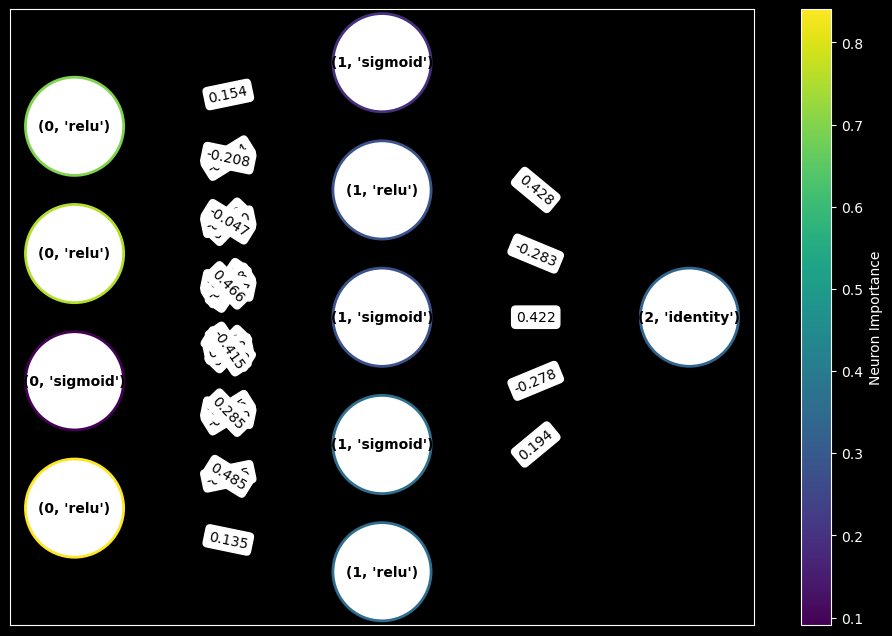

In [ ]:
#| test
test_config = MLPConfig(input_size=1, output_size=1, hidden_sizes=[4, 5], initial_activation_list=[jax.nn.relu, jax.nn.sigmoid], seed=0)
mlp = CustomMLP(test_config)

G, neuron_labels, neuron_importances = mlp.visualize_graph()
fig = mlp_plot(G, neuron_labels, neuron_importances)
plt.show()

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()